### 20180417: for bird_tw with 73 classes 

In [1]:
from scipy import io
import pandas as pd
import numpy as np
import time
import pickle
import os
import h5py
import sys, getopt
import datetime
from io_utils_mod import HDF5Matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
# from MapCallback import MapCallback

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
hdf5path = '../data/all_data.hdf5' # training data generated by loadData.py
modelName2Save = 'trainModel_InceptionV3_1-v5_bird_tw.h5'

In [3]:
modelPath = 'InceptionV3' #M: 沒用
logfileName = 'log.xls' #M: 沒用
#scalerFilePath = '../birdclef_data/standardScaler_5000.pickle'
scalerFilePath = None
preTrainedModelWeightsPath = None # path and filename to pretrained network: if there is a pretrained network, we can load it and continue to train it
tensorflowBackend = False # set true if Keras has TensorFlow backend - this way we set TF not to allocate all the GPU memory

if (tensorflowBackend):
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    from keras import backend as K
    K.set_session(sess)

print('hdf5path: %s, scalerFilePath: %s' % (hdf5path,scalerFilePath))

hdf5path: ../data/all_data.hdf5, scalerFilePath: None


In [4]:
scaler = None
scaleData = None
# if a scaler file generated by loadData.py is given, than load it and define a scaler function that will be used later
if scalerFilePath is not None:
    scaler = pickle.load(open(scalerFilePath, 'rb'))
    # Can't use scaler.transform because it only supports 2d arrays.
    def scaleData(X):
        return (X-scaler.mean_)/scaler.scale_

In [5]:
f = h5py.File(hdf5path, 'r')
X = f.get('X')
y = f.get('y')
print("Shape of X:", X.shape)
dataSetLength = X.shape[0]
output_dim = y.shape[1] #len(y_train[0])
f.close()
print('dataSetLength={}'.format(dataSetLength))
print('output_dim={}'.format(output_dim))

Shape of X: (16262, 1, 200, 310)
dataSetLength=16262
output_dim=73


In [6]:
X = np.array(HDF5Matrix(hdf5path, 'X', 0, dataSetLength, normalizer = scaleData))
y = np.array(HDF5Matrix(hdf5path, 'y', 0, dataSetLength))

#M: vvv 再多 shuffle 幾次...
X, y = shuffle(X, y, random_state=4)
X, y = shuffle(X, y)
X, y = shuffle(X, y)
X, y = shuffle(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, test_size = 0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state = 3, test_size = 0.1)

print('   X_train, y_train=', X_train.shape, y_train.shape, type(X_train), type(y_train))
print('   X_validation, y_validation=', X_validation.shape, y_validation.shape)
print('   X_test, y_test=', X_test.shape, y_test.shape)

   X_train, y_train= (13171, 1, 200, 310) (13171, 73) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
   X_validation, y_validation= (1464, 1, 200, 310) (1464, 73)
   X_test, y_test= (1627, 1, 200, 310) (1627, 73)


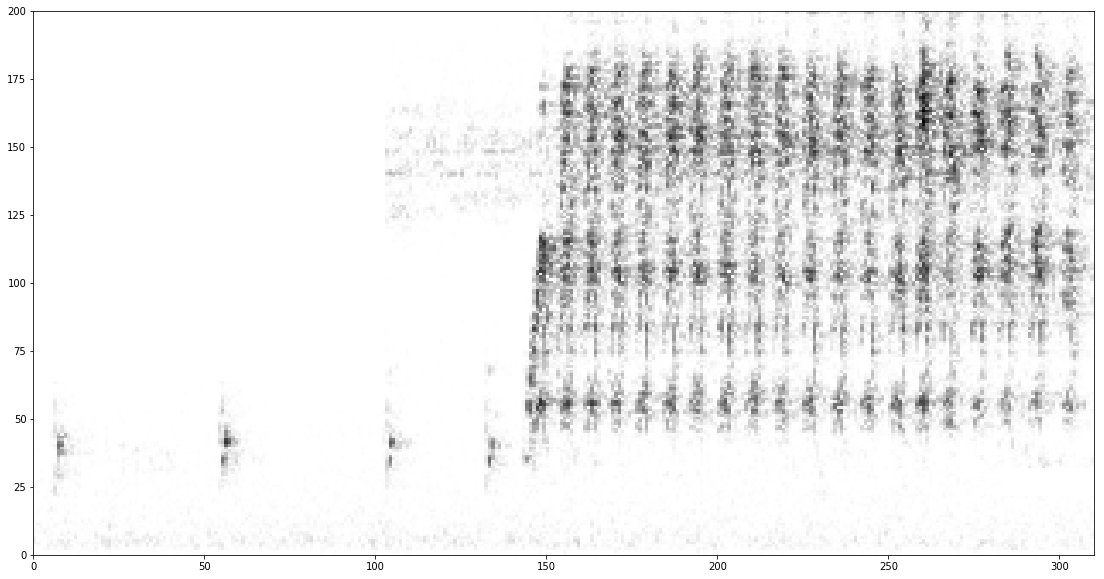

In [8]:
#M: 隨便抽張圖看看...
i=1
img = X_train[i].reshape((200,310))
fig = plt.figure(figsize=(19,10))
plt.tight_layout()
plt.pcolormesh(img, cmap=plt.cm.binary)
plt.show()

### vvvvv 將 AlexNet 換成 InceptionV3 Model vvvvv

In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam #M: 用 Adam, Nadam 沒用.
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras.backend as K

Using TensorFlow backend.


In [10]:
K.set_image_data_format('channels_first')
model = InceptionV3(include_top=False, weights=None, input_shape=(1,200,310), pooling='avg')

input_tensor = model.input
# build top
x = model.output
#M: 多加一層 128 dense layer
x = Dropout(.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(output_dim, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

model.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 200, 310)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 99, 154)  288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 99, 154)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 99, 154)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### ^^^^^ 將 AlexNet 換成 InceptionV3 Model ^^^^^

In [12]:
nb_epochs = 20000 # number of epochs, should be high, the end of the learning process is controled by early stoping
es_patience = 150 # patience for early stoping 
batchSize = 100 # batch size for mini-batch training

In [13]:
# lr decay schedule
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """

    lr = 1e-3
    decay = int(epoch / 100)
    if decay != 0:
        lr /= (10 ** decay)
    print('Learning rate = {}, decay = {}'.format(lr, decay))
    return lr

In [14]:
# call backs
if os.path.exists('./modelWeights/') is False:
    os.mkdir('./modelWeights/') #M:
checkpointer = ModelCheckpoint(filepath='./modelWeights/weights.h5', verbose=1, save_best_only=True)
lr = LearningRateScheduler(lr_schedule)

In [15]:
# load model and compile it, we use RMSprop here, other optimizer algorithm should be tested
# execfile(modelPath)
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')#, metrics=["accuracy"])

# print the model
# print("The following model is used: ")
# for layer in model.layers:
#     print("{} output shape: {}".format(layer.name, layer.output_shape))

# load pretrained model if it is set
# if preTrainedModelWeightsPath is not None:
#     model.load_weights(preTrainedModelWeightsPath)
#     print("Reloaded weights from: {}".format(preTrainedModelWeightsPath))

# define callback functions
# mapcallback = MapCallback()

earlyStopping = EarlyStopping(monitor='val_loss', patience = es_patience) # early stoping

# save best models based on accuracy, loss and MAP metrics
#bestModelFilePath_val_map = './modelWeights/best_val_map_{}_{}.hdf5'.format(output_dim, datetime.datetime.now().strftime('%Y-%m-%d-%M-%S'))
#bestModelFilePath_val_acc = './modelWeights/best_val_acc_{}_{}.hdf5'.format(output_dim, datetime.datetime.now().strftime('%Y-%m-%d-%M-%S'))
#bestModelFilePath_val_loss = './modelWeights/best_val_loss_{}_{}.hdf5'.format(output_dim, datetime.datetime.now().strftime('%Y-%m-%d-%M-%S'))


# bestModelFilePath_val_acc = './modelWeights/best_val_acc_{}.hdf5'.format(output_dim)
# bestModelFilePath_val_loss = './modelWeights/best_val_loss_{}.hdf5'.format(output_dim)
# bestModelFilePath_val_map = './modelWeights/best_val_map_{}.hdf5'.format(output_dim)
# checkpointer_val_acc = ModelCheckpoint(filepath = bestModelFilePath_val_acc, verbose = 1, monitor = 'val_acc', save_best_only = True)
# checkpointer_val_loss = ModelCheckpoint(filepath = bestModelFilePath_val_loss, verbose = 1, monitor = 'val_loss', save_best_only = True)
# checkpointer_val_map = ModelCheckpoint(filepath = bestModelFilePath_val_map, verbose = 1, monitor = 'val_map', mode = 'max', save_best_only = True)

In [ ]:
# store the starting time 
startTime = time.time()

fitting_result = model.fit(X_train, y_train, epochs = nb_epochs, batch_size = batchSize, shuffle = True, callbacks = [earlyStopping, checkpointer, lr], validation_data = (X_validation, y_validation))

# calculate the elapsed time
elapsed = time.time()-startTime;
print("Execution time: {0} s".format(elapsed))

# save model
model.save(modelName2Save)

Train on 13171 samples, validate on 1464 samples
Learning rate = 0.001, decay = 0
Epoch 1/20000
13100/13171 [============================>.] - ETA: 0s - loss: 3.8197 - acc: 0.1556
Epoch 00001: val_loss improved from inf to 4.69449, saving model to ./modelWeights/weights.h5
13171/13171 [==============================] - 108s 8ms/step - loss: 3.8172 - acc: 0.1560 - val_loss: 4.6945 - val_acc: 0.1189
Learning rate = 0.001, decay = 0
Epoch 2/20000
13100/13171 [============================>.] - ETA: 0s - loss: 3.3833 - acc: 0.2191
Epoch 00002: val_loss did not improve
13171/13171 [==============================] - 68s 5ms/step - loss: 3.3821 - acc: 0.2190 - val_loss: 5.0665 - val_acc: 0.2281
Learning rate = 0.001, decay = 0
Epoch 3/20000
13100/13171 [============================>.] - ETA: 0s - loss: 3.0726 - acc: 0.2673
Epoch 00003: val_loss did not improve
13171/13171 [==============================] - 69s 5ms/step - loss: 3.0719 - acc: 0.2675 - val_loss: 5.0342 - val_acc: 0.2288
Learning 

13100/13171 [============================>.] - ETA: 0s - loss: 0.4267 - acc: 0.8822
Epoch 00026: val_loss did not improve
13171/13171 [==============================] - 69s 5ms/step - loss: 0.4259 - acc: 0.8822 - val_loss: 1.2891 - val_acc: 0.7473
Learning rate = 0.001, decay = 0
Epoch 27/20000
13100/13171 [============================>.] - ETA: 0s - loss: 0.4264 - acc: 0.8822
Epoch 00027: val_loss did not improve
13171/13171 [==============================] - 69s 5ms/step - loss: 0.4261 - acc: 0.8822 - val_loss: 1.3511 - val_acc: 0.7213
Learning rate = 0.001, decay = 0
Epoch 28/20000
13100/13171 [============================>.] - ETA: 0s - loss: 0.3714 - acc: 0.8993
Epoch 00028: val_loss did not improve
13171/13171 [==============================] - 69s 5ms/step - loss: 0.3715 - acc: 0.8994 - val_loss: 1.6098 - val_acc: 0.6940
Learning rate = 0.001, decay = 0
Epoch 29/20000
13100/13171 [============================>.] - ETA: 0s - loss: 0.3355 - acc: 0.9068
Epoch 00029: val_loss improv

In [18]:
# convert the output (probabilistics) to classes
def proba_to_class(a):
    classCount = len(a[0])
    print('proba_to_class:classCount={}'.format(classCount)) #M:
    to_return = np.empty((0,classCount))
    for row in a:
        maxind = np.argmax(row)
        to_return = np.vstack((to_return, [1 if i == maxind else 0 for i in range(classCount)]))
    return to_return

In [19]:
# calculate metrics on test data with the last model 
from sklearn.metrics import average_precision_score, accuracy_score
y_result = model.predict(X_test)
y_argmax = np.argmax(y_result, axis=1)
y_argmax

array([32,  6, 29,  3, 16, 11, 34, 12, 20, 32, 13,  4, 10, 26, 16, 29, 34,
       33,  4,  8, 11, 28, 15, 33,  3,  2, 11, 16, 10, 33, 16, 32, 18, 31,
       27, 17, 11, 33, 27,  0, 24, 14, 25, 29, 29, 27,  4, 11, 11, 15, 13,
       24,  2, 34,  4, 22, 11, 32, 11, 11, 24, 17, 10, 11, 12, 26,  0,  0,
        3, 11, 28, 27,  1,  6, 20, 12,  6, 33, 24, 15,  7, 16, 34, 16, 17,
       21, 11, 10, 19, 28, 27, 32,  9, 26,  4, 22, 25, 18, 20, 31,  4,  7,
       20, 28, 11, 28, 15,  1, 10, 34, 12, 27, 11,  0, 24, 27,  4, 33, 33,
       33, 22,  0, 16, 28, 34, 32, 32, 12, 22, 16,  4, 33, 29, 32,  4,  2,
       21, 28, 28, 16, 33,  2, 15,  7, 34, 33,  8,  6, 11, 16,  7,  0, 28,
       14,  4, 20, 16,  6, 21, 16, 16, 32, 15, 28, 11,  3, 11, 34, 32, 27,
       24, 34, 11,  6, 16, 24, 27, 15,  3,  4, 33, 16, 29, 33, 27, 27, 27,
       27, 28, 27])

In [20]:
y_real = np.argmax(y_test, axis=1)
y_real

array([32,  6, 29,  3, 16, 11, 34, 12, 20, 32, 13,  4, 10, 26, 16, 29, 34,
       33,  4,  8, 11, 28, 15, 33,  3,  2, 11, 16, 10, 33, 16, 32, 18, 31,
       27, 17, 11, 33, 27,  0, 24, 14, 25, 29, 29, 27,  4, 11, 11, 15, 13,
       24,  2,  6,  4, 22, 11, 32, 11, 11, 24, 17, 10, 11, 12, 26,  0,  0,
        3, 11, 28, 27,  1,  6, 20, 12, 25, 33, 24, 15,  7, 16, 34, 16, 17,
       21, 11, 10, 19, 28, 27, 32,  9, 21,  4, 22, 25, 26, 20, 31,  4,  7,
       20, 28, 11, 28, 15,  1, 10,  6, 12, 27, 11,  0, 24, 27,  4, 33, 25,
       33, 22,  0, 16, 28, 34, 32, 32, 12, 22, 16,  4, 33, 29, 32,  4,  2,
       28, 28, 28, 16, 33,  2, 15,  7, 34, 33,  8,  6, 11, 16,  7,  0, 28,
       14,  4, 20, 16,  6, 21, 16, 16, 32, 15, 28, 11,  3, 11, 34, 32, 27,
       24, 34, 11,  6, 16, 24, 27, 15,  3,  4, 33, 16, 29, 33, 27, 27, 27,
       27, 28, 27])

In [21]:
# calculate metrics on test data with the last model 
from sklearn.metrics import average_precision_score, accuracy_score

map = average_precision_score(y_test, y_result, average='micro')
print("AveragePrecision: {}".format(map))

accuracy = accuracy_score(y_test, proba_to_class(y_result))
print("Accuracy: {}".format(accuracy))

AveragePrecision: 0.9680727521905285


In [ ]:
# # reload the best model with smallest validation loss and calculate metrics on test data
# print("----- Loading best model from: {}  -------".format(bestModelFilePath_val_loss))
# model.load_weights(bestModelFilePath_val_loss)
# y_result_bm = model.predict(X_test)
# map_bm_val_loss = average_precision_score( y_test.data[y_test.start: y_test.end], y_result_bm, average='macro')
# accuracy_bm_val_loss = accuracy_score(y_test.data[y_test.start: y_test.end], proba_to_class(y_result_bm))
# print("AveragePrecision: {}".format(map_bm_val_loss))
# print("Accuracy: {}".format(accuracy_bm_val_loss))

In [ ]:
# # reload the best model with highest validation accuracy and calculate metrics on test data
# print("----- Loading best model from: {}  -------".format(bestModelFilePath_val_acc))
# model.load_weights(bestModelFilePath_val_acc)
# y_result_bm = model.predict(X_test)
# map_bm_val_acc = average_precision_score( y_test.data[y_test.start: y_test.end], y_result_bm, average='macro')
# accuracy_bm_val_acc = accuracy_score(y_test.data[y_test.start: y_test.end], proba_to_class(y_result_bm))
# print("AveragePrecision: {}".format(map_bm_val_acc))
# print("Accuracy: {}".format(accuracy_bm_val_acc))

In [ ]:
# # save the results summery into an excel file
# import log
# log.logToXLS(logfileName, model, fitting_result, {'execution(s)':elapsed, 'map':map, 'accuracy':accuracy, 'map_bm_val_loss':map_bm_val_loss, 'accuracy_bm_val_loss':accuracy_bm_val_loss,'map_bm_val_acc':map_bm_val_acc, 'accuracy_bm_val_acc':accuracy_bm_val_acc, 'modelPyFile': modelPath})